In [248]:
library(dplyr)
library(ggplot2)
library(rlang)

In [249]:
options(repr.plot.width = 8, repr.plot.height = 8)

In [250]:
# Load the data
df <- read.csv("food_prices_ph.csv", stringsAsFactors = TRUE)

# Check the structure of the data
str(df)

'data.frame':	104147 obs. of  11 variables:
 $ Date      : Factor w/ 264 levels "2000-01-15","2000-02-15",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Region    : Factor w/ 17 levels "Autonomous region in Muslim Mindanao",..: 3 3 3 3 3 3 6 6 6 9 ...
 $ Location  : Factor w/ 79 levels "Abra","Agusan del Norte",..: 46 46 46 46 46 46 54 54 54 79 ...
 $ Market    : Factor w/ 108 levels "Abra","Agusan del Norte",..: 64 64 64 64 64 64 77 77 77 105 ...
 $ Category  : Factor w/ 6 levels "cereals and tubers",..: 1 1 1 1 1 2 1 1 2 1 ...
 $ Commodity : Factor w/ 73 levels "Anchovies","Bananas (lakatan)",..: 39 56 56 59 59 46 56 56 46 59 ...
 $ Unit      : Factor w/ 3 levels "750 ML","KG",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Price.Flag: Factor w/ 2 levels "actual","aggregate": 1 1 1 1 1 1 1 1 1 1 ...
 $ Price.Type: Factor w/ 3 levels "Farm Gate","Retail",..: 2 2 3 2 3 2 2 3 2 2 ...
 $ Currency  : Factor w/ 1 level "PHP": 1 1 1 1 1 1 1 1 1 1 ...
 $ Price     : num  15 20 18.4 18 16.4 ...


In [251]:
# Check the first 6 rows in the dataframe (df)
head(df)

,Date,Region,Location,Market,Category,Commodity,Unit,Price.Flag,Price.Type,Currency,Price
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,cereals and tubers,Maize flour (yellow),KG,actual,Retail,PHP,15.00
2,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,cereals and tubers,"Rice (milled, superior)",KG,actual,Retail,PHP,20.00
3,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,cereals and tubers,"Rice (milled, superior)",KG,actual,Wholesale,PHP,18.35
4,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,cereals and tubers,"Rice (regular, milled)",KG,actual,Retail,PHP,18.00
5,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,cereals and tubers,"Rice (regular, milled)",KG,actual,Wholesale,PHP,16.35
6,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,"meat, fish and eggs",Meat (pork),KG,actual,Retail,PHP,105.37


In [252]:
# check df dimensions; check for the # of rows as observations
dim(df)

[1] 104147     11

In [253]:
# Check the column names
colnames(df)

[1] "Date"       "Region"     "Location"   "Market"     "Category"  
 [6] "Commodity"  "Unit"       "Price.Flag" "Price.Type" "Currency"  
[11] "Price"

In [254]:
# Check for missing values in each column
colSums(is.na(df))

Date     Region   Location     Market   Category  Commodity       Unit 
         0          0          0          0          0          0          0 
Price.Flag Price.Type   Currency      Price 
         0          0          0          0

In [255]:
# Check for duplicate rows
duplicates <- duplicated(df)
sum(duplicates)

[1] 0

In [256]:
# Identify numeric columns
numeric_cols <- names(df)[sapply(df, is.numeric)]

# Identify categorical (factor) columns
categorical_cols <- names(df)[sapply(df, is.factor)]

# Output the results
numeric_cols
categorical_cols


[1] "Price"

[1] "Date"       "Region"     "Location"   "Market"     "Category"  
 [6] "Commodity"  "Unit"       "Price.Flag" "Price.Type" "Currency"

In [257]:
# Function to detect outliers based on IQR
detect_outliers <- function(df) {
  outliers <- sapply(df, function(x) {
    if (is.numeric(x)) {
      Q1 <- quantile(x, 0.25, na.rm = TRUE)
      Q3 <- quantile(x, 0.75, na.rm = TRUE)
      IQR <- Q3 - Q1
      lower_bound <- Q1 - 1.5 * IQR
      upper_bound <- Q3 + 1.5 * IQR
      sum(x < lower_bound | x > upper_bound, na.rm = TRUE)
    } else {
      return(0)
    }
  })
  
  return(outliers)
}

# Detect outliers in numeric columns
outlier_counts <- detect_outliers(df)
outlier_counts


Date     Region   Location     Market   Category  Commodity       Unit 
         0          0          0          0          0          0          0 
Price.Flag Price.Type   Currency      Price 
         0          0          0       4936

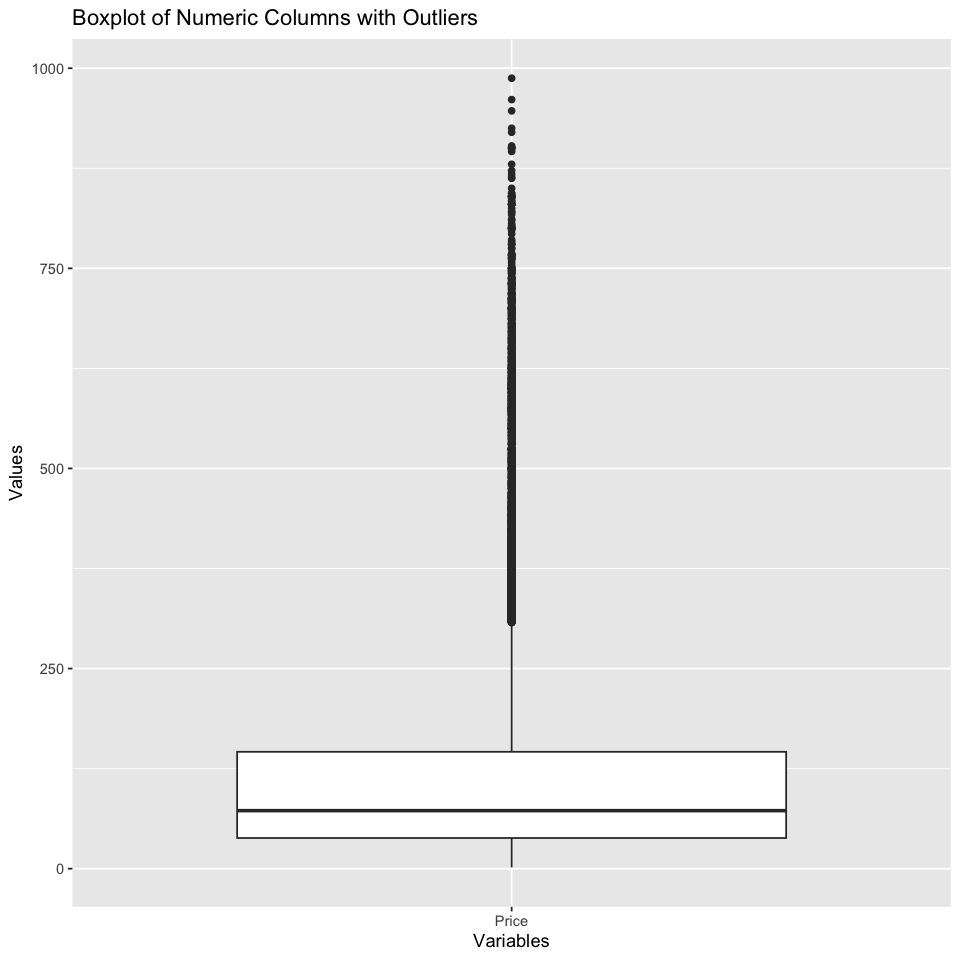

In [258]:
# Visualize the numeric columns with outliers using box plot
numeric_columns <- sapply(df, is.numeric)
df_numeric <- df[, numeric_columns, drop = FALSE]  # Ensure we're working only with numeric data

# Check if df_numeric is empty or contains NA values
if (ncol(df_numeric) == 0) {
  stop("There are no numeric columns in the dataframe.")
}

# Create box plot for numeric columns with outliers using stack
ggplot(stack(df_numeric), aes(x = ind, y = values)) +
  geom_boxplot() +
  xlab('Variables') + ylab('Values') + 
  ggtitle('Boxplot of Numeric Columns with Outliers')

In [259]:
# Adjust the multiplier to be more strict (e.g., 2.5 * IQR or 3 * IQR)
remove_outliers <- function(df, factor = 1.5) {
  df_no_outliers <- df
  for (i in 1:ncol(df)) {
    if (is.numeric(df[[i]])) {
      Q1 <- quantile(df[[i]], 0.25, na.rm = TRUE)
      Q3 <- quantile(df[[i]], 0.75, na.rm = TRUE)
      IQR <- Q3 - Q1
      lower_bound <- Q1 - factor * IQR
      upper_bound <- Q3 + factor * IQR
      df_no_outliers <- df_no_outliers[df[[i]] >= lower_bound & df[[i]] <= upper_bound, ]
    }
  }
  return(df_no_outliers)
}

# Remove outliers using a stricter threshold (e.g., 2.5 * IQR)
# Avoid over removal of outliers to preserve context
# There is no rule how many are allowed in the study but not more than 10% of total # of observations
df_no_outliers <- remove_outliers(df)

# Check outliers again in the cleaned dataset
outlier_counts_after_removal <- detect_outliers(df_no_outliers)
outlier_counts_after_removal



Date     Region   Location     Market   Category  Commodity       Unit 
         0          0          0          0          0          0          0 
Price.Flag Price.Type   Currency      Price 
         0          0          0       2081

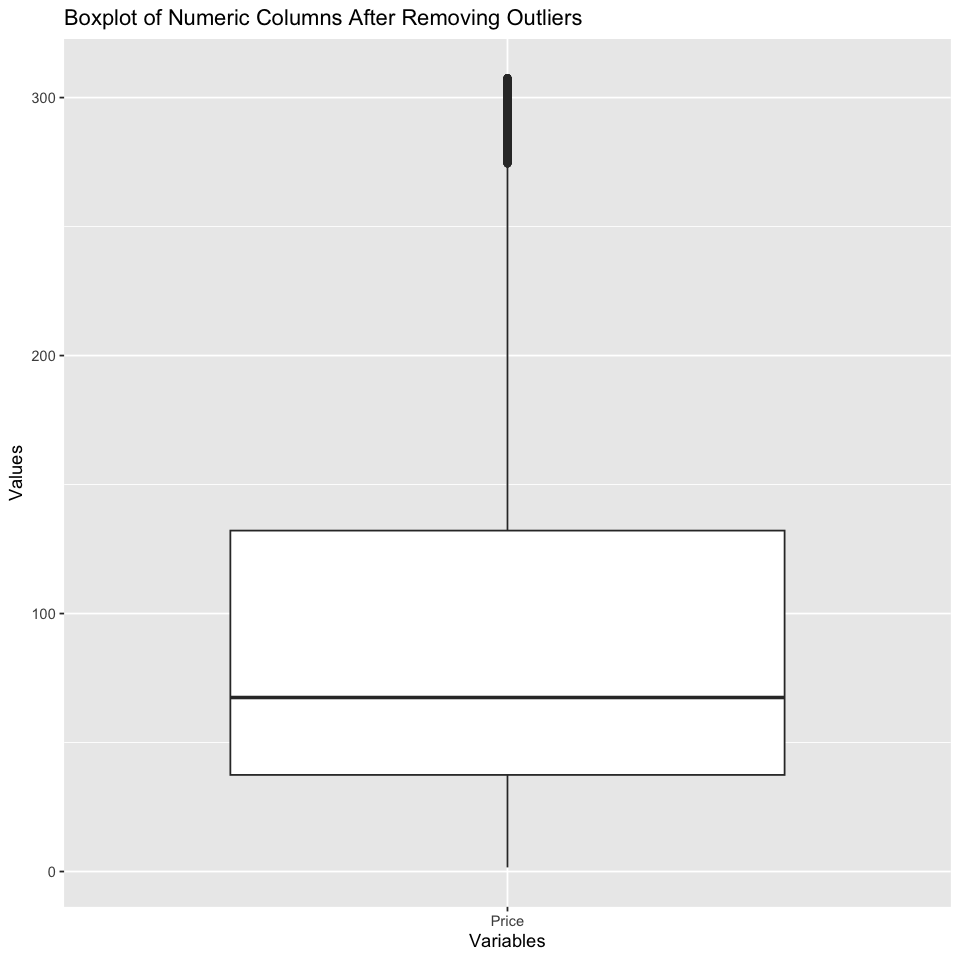

In [260]:
# Visualize the data after removing outliers using box plot
df_numeric_no_outliers <- df_no_outliers[, numeric_columns, drop = FALSE]

# Create box plot for numeric columns after removing outliers
ggplot(stack(df_numeric_no_outliers), aes(x = ind, y = values)) +
  geom_boxplot() +
  xlab('Variables') + ylab('Values') + 
  ggtitle('Boxplot of Numeric Columns After Removing Outliers')


In [261]:
# Function to detect outliers (same as before)
detect_outliers <- function(df) {
  outliers <- sapply(df, function(x) {
    if (is.numeric(x)) {
      Q1 <- quantile(x, 0.25, na.rm = TRUE)
      Q3 <- quantile(x, 0.75, na.rm = TRUE)
      IQR <- Q3 - Q1
      lower_bound <- Q1 - 1.5 * IQR
      upper_bound <- Q3 + 1.5 * IQR
      sum(x < lower_bound | x > upper_bound, na.rm = TRUE)
    } else {
      return(0)
    }
  })
  
  return(outliers)
}

# Re-run the outlier detection on the dataset after removing outliers
outlier_counts_after_removal <- detect_outliers(df_no_outliers)

# Display the count of remaining outliers
outlier_counts_after_removal


Date     Region   Location     Market   Category  Commodity       Unit 
         0          0          0          0          0          0          0 
Price.Flag Price.Type   Currency      Price 
         0          0          0       2081

In [262]:
dim(df_no_outliers)

[1] 99211    11

In [263]:
write.csv(df_no_outliers, "food_prices_ph_cleaned.csv")